<a href="https://colab.research.google.com/github/edosept/transferLearning/blob/master/Transfer_Learning_Multilabel_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install jcopdl

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
root_dir = "/content/drive/My Drive/Colab Notebooks/transferLearning"

In [4]:
import numpy as np
import torch
from torch import nn, optim
from torchvision import transforms

import matplotlib.pyplot as plt
import os
from sklearn.metrics import hamming_loss

from IPython.display import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Helper Function and Class

In [5]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import PIL
import pandas as pd
class Dataset(Dataset):
    def __init__(self, csv_path, img_path, transform=None):

        df = pd.read_csv(csv_path)
        assert df['fname'].apply(lambda x: os.path.isfile(img_path + x)).all
        
        self.img_path = img_path
        self.transform = transform

        self.X = df['fname']
        self.y = df.drop(columns=['fname'])

    def __getitem__(self, index):
        
        img = PIL.Image.open(self.img_path + self.X[index])
        if self.transform is not None:
            img = self.transform(img)
        
        label = torch.from_numpy(self.y.iloc[index].values).type(torch.FloatTensor)
        return img, label

    def __len__(self):
        return len(self.X)

def label2cat(x):
    return [label for i, label in enumerate(["desert", "mountains", "sea", "sunset", "trees"]) if x[i] == 1]

def inv_norm(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    x = image.new(*image.size())    
    x[:, 0, :, :] = image[:, 0, :, :] * std[0] + mean[0]
    x[:, 1, :, :] = image[:, 1, :, :] * std[1] + mean[1]
    x[:, 2, :, :] = image[:, 2, :, :] * std[2] + mean[2]    
    return x

# Import Data (Dataset, Dataloader)

In [6]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

bs = 32
train_set = Dataset("/content/drive/My Drive/Colab Notebooks/transferLearning/data/train_label.csv", "/content/drive/My Drive/Colab Notebooks/transferLearning/data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

test_set = Dataset("/content/drive/My Drive/Colab Notebooks/transferLearning/data/test_label.csv", "/content/drive/My Drive/Colab Notebooks/transferLearning/data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

# Visualize Data

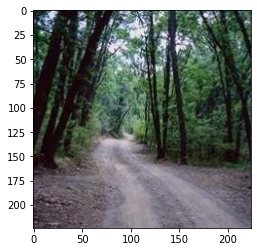

In [7]:
images, labels = next(iter(testloader))
images = inv_norm(images)
images = images.numpy()[0, :, : ,:]
images = images.transpose([1, 2, 0])
plt.imshow(images);

# Construct MCOS

In [8]:
from torchvision.models import resnet18
model = resnet18(pretrained=True) #artinya kita mau pakai resnet yang sudah di pretrained

#frezze semua weightnya
for param in model.parameters():
    param.requires_grad = False

#edit kepalanya
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 5),
    nn.Sigmoid() #sigmoid karena multilabel
)
model = model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, min_lr=1e-8)

### Phase 1: Training Classifier

In [9]:
# Config
model_name = 'resnet.pth'
save_every = 10
plot_every = 10
early_stop_patience = 10

# Initialization
train_cost, test_cost = [], []
train_acc, test_acc = [], []
best_acc = 0
best_weights = model.state_dict()
epoch = early_stop = 0

In [10]:
from tqdm import tqdm #tqdm melihat progress dari looping, means "progress" in Arabic (taqadum)
#bisa lihat estimate time juga

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch    1
Train_loss = 0.607 | Test_loss = 0.569
Train_acc = 70.4% | Test_acc = 74.5%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch    2
Train_loss = 0.555 | Test_loss = 0.538
Train_acc = 75.1% | Test_acc = 75.3%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch    3
Train_loss = 0.531 | Test_loss = 0.513
Train_acc = 75.2% | Test_acc = 75.7%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch    4
Train_loss = 0.508 | Test_loss = 0.491
Train_acc = 75.8% | Test_acc = 76.4%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch    5
Train_loss = 0.489 | Test_loss = 0.467
Train_acc = 76.9% | Test_acc = 77.6%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch    6
Train_loss = 0.475 | Test_loss = 0.452
Train_acc = 77.4% | Test_acc = 78.7%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch    7
Train_loss = 0.458 | Test_loss = 0.435
Train_acc = 78.2% | Test_acc = 79.8%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch    8
Train_loss = 0.443 | Test_loss = 0.423
Train_acc = 79.5% | Test_acc = 81.2%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch    9
Train_loss = 0.429 | Test_loss = 0.410
Train_acc = 79.8% | Test_acc = 82.6%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   10
Train_loss = 0.419 | Test_loss = 0.396
Train_acc = 81.7% | Test_acc = 82.8%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   11
Train_loss = 0.409 | Test_loss = 0.387
Train_acc = 81.9% | Test_acc = 84.9%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   12
Train_loss = 0.398 | Test_loss = 0.374
Train_acc = 82.0% | Test_acc = 85.0%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   13
Train_loss = 0.394 | Test_loss = 0.369
Train_acc = 82.8% | Test_acc = 85.0%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   14
Train_loss = 0.383 | Test_loss = 0.364
Train_acc = 83.0% | Test_acc = 85.8%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   15
Train_loss = 0.377 | Test_loss = 0.348
Train_acc = 83.8% | Test_acc = 85.7%
==> EarlyStop patience = 1


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   16
Train_loss = 0.370 | Test_loss = 0.345
Train_acc = 84.9% | Test_acc = 87.0%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   17
Train_loss = 0.364 | Test_loss = 0.335
Train_acc = 84.8% | Test_acc = 87.1%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   18
Train_loss = 0.359 | Test_loss = 0.332
Train_acc = 85.2% | Test_acc = 87.5%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   19
Train_loss = 0.353 | Test_loss = 0.326
Train_acc = 85.6% | Test_acc = 88.3%


100%|██████████| 51/51 [00:13<00:00,  3.72it/s]


Epoch   20
Train_loss = 0.351 | Test_loss = 0.322
Train_acc = 85.7% | Test_acc = 87.6%
==> EarlyStop patience = 1


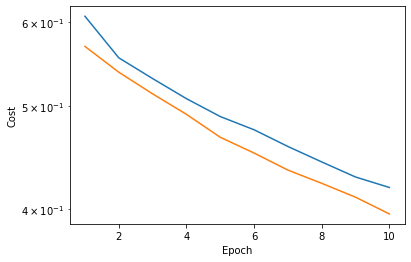

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   21
Train_loss = 0.349 | Test_loss = 0.316
Train_acc = 85.7% | Test_acc = 87.8%
==> EarlyStop patience = 2


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   22
Train_loss = 0.343 | Test_loss = 0.315
Train_acc = 86.0% | Test_acc = 88.7%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   23
Train_loss = 0.339 | Test_loss = 0.307
Train_acc = 86.3% | Test_acc = 88.4%
==> EarlyStop patience = 1


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   24
Train_loss = 0.339 | Test_loss = 0.301
Train_acc = 86.2% | Test_acc = 89.1%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   25
Train_loss = 0.337 | Test_loss = 0.303
Train_acc = 86.4% | Test_acc = 88.4%
==> EarlyStop patience = 1


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   26
Train_loss = 0.332 | Test_loss = 0.299
Train_acc = 86.4% | Test_acc = 88.6%
==> EarlyStop patience = 2


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   27
Train_loss = 0.327 | Test_loss = 0.295
Train_acc = 86.8% | Test_acc = 88.8%
==> EarlyStop patience = 3


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   28
Train_loss = 0.324 | Test_loss = 0.293
Train_acc = 86.7% | Test_acc = 88.8%
==> EarlyStop patience = 4


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   29
Train_loss = 0.322 | Test_loss = 0.289
Train_acc = 86.8% | Test_acc = 88.9%
==> EarlyStop patience = 5


100%|██████████| 51/51 [00:13<00:00,  3.70it/s]


Epoch   30
Train_loss = 0.318 | Test_loss = 0.287
Train_acc = 87.2% | Test_acc = 89.3%


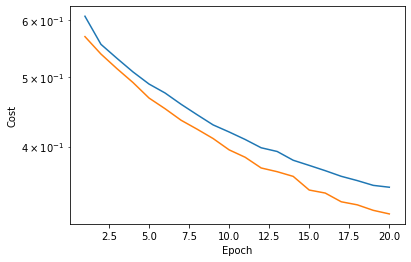

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   31
Train_loss = 0.319 | Test_loss = 0.286
Train_acc = 87.2% | Test_acc = 89.8%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   32
Train_loss = 0.315 | Test_loss = 0.283
Train_acc = 87.3% | Test_acc = 89.3%
==> EarlyStop patience = 1


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   33
Train_loss = 0.317 | Test_loss = 0.282
Train_acc = 87.2% | Test_acc = 89.6%
==> EarlyStop patience = 2


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   34
Train_loss = 0.309 | Test_loss = 0.281
Train_acc = 87.8% | Test_acc = 89.3%
==> EarlyStop patience = 3


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   35
Train_loss = 0.311 | Test_loss = 0.272
Train_acc = 87.5% | Test_acc = 89.8%
==> EarlyStop patience = 4


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   36
Train_loss = 0.306 | Test_loss = 0.277
Train_acc = 87.8% | Test_acc = 90.0%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   37
Train_loss = 0.312 | Test_loss = 0.273
Train_acc = 87.5% | Test_acc = 89.9%
==> EarlyStop patience = 1


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   38
Train_loss = 0.308 | Test_loss = 0.274
Train_acc = 87.5% | Test_acc = 90.1%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   39
Train_loss = 0.306 | Test_loss = 0.273
Train_acc = 87.8% | Test_acc = 89.5%
==> EarlyStop patience = 1


100%|██████████| 51/51 [00:14<00:00,  3.59it/s]


Epoch   40
Train_loss = 0.299 | Test_loss = 0.270
Train_acc = 87.9% | Test_acc = 89.4%
==> EarlyStop patience = 2


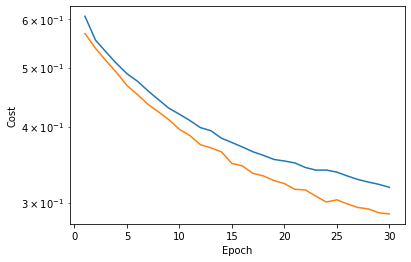

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   41
Train_loss = 0.304 | Test_loss = 0.275
Train_acc = 87.8% | Test_acc = 89.6%
==> EarlyStop patience = 3


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   42
Train_loss = 0.297 | Test_loss = 0.267
Train_acc = 88.4% | Test_acc = 90.1%
==> EarlyStop patience = 4


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   43
Train_loss = 0.301 | Test_loss = 0.273
Train_acc = 88.0% | Test_acc = 89.6%
==> EarlyStop patience = 5


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   44
Train_loss = 0.301 | Test_loss = 0.271
Train_acc = 88.3% | Test_acc = 89.3%
==> EarlyStop patience = 6


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   45
Train_loss = 0.295 | Test_loss = 0.266
Train_acc = 88.2% | Test_acc = 89.7%
==> EarlyStop patience = 7


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   46
Train_loss = 0.301 | Test_loss = 0.265
Train_acc = 88.1% | Test_acc = 89.8%
==> EarlyStop patience = 8


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   47
Train_loss = 0.296 | Test_loss = 0.267
Train_acc = 88.2% | Test_acc = 89.6%
==> EarlyStop patience = 9


100%|██████████| 51/51 [00:13<00:00,  3.72it/s]


Epoch   48
Train_loss = 0.303 | Test_loss = 0.266
Train_acc = 87.3% | Test_acc = 89.9%
==> EarlyStop patience = 10
==> Execute Early Stopping


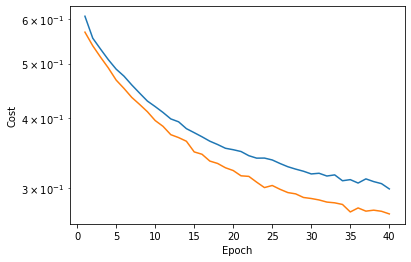

In [11]:
import os
while True:
    epoch += 1
    
    ## Training ##
    cost = acc = 0
    model.train()    
    for images, labels in tqdm(trainloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        cost += loss.item()*images.shape[0]
        labels = labels.cpu().detach().numpy()
        pred = output > 0.5
        pred = pred.cpu().detach().numpy()                
        acc += (1-hamming_loss(labels, pred))
    scheduler.step(cost)
    train_cost.append(cost/len(trainloader.dataset))
    train_acc.append(acc/len(trainloader))
    
    ## Testing ##
    with torch.no_grad():
        cost = acc = 0
        model.eval()
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
        
            output = model(images)
            loss = criterion(output, labels)            
            
            cost += loss.item()*images.shape[0]
            labels = labels.cpu().detach().numpy()
            pred = output > 0.5
            pred = pred.cpu().detach().numpy()                
            acc += (1-hamming_loss(labels, pred))
        scheduler.step(cost)
        test_cost.append(cost/len(testloader.dataset))
        test_acc.append(acc/len(testloader))
        
    ## Reporting ##
    print(f'Epoch {epoch:4}')
    print(f'Train_loss = {train_cost[-1]:.3f} | Test_loss = {test_cost[-1]:.3f}')
    print(f'Train_acc = {train_acc[-1]*100:.1f}% | Test_acc = {test_acc[-1]*100:.1f}%')    
    
    
    ## Common Callback ##
    # Early Stopping
    if test_acc[-1] > best_acc:
        best_acc = test_acc[-1]
        best_weights = model.state_dict()
        early_stop = 0
    else:
        early_stop += 1
        print(f'==> EarlyStop patience = {early_stop}')
        if early_stop >= early_stop_patience:
            print('==> Execute Early Stopping')
            ckpt = {
                'loss_history': (train_cost, test_cost),
                'acc_history': (train_acc, test_acc),
                'weight': best_weights
            }
            os.makedirs('model', exist_ok=True)
            torch.save(ckpt, f'model/{model_name}')
            break

    # Checkpoint            
    if epoch % save_every == 0:
        ckpt = {
            'loss_history': (train_cost, test_cost),
            'acc_history': (train_acc, test_acc),
            'weight': best_weights
        }
        os.makedirs('model', exist_ok=True)
        torch.save(ckpt, f'model/{model_name}')
        
    # Runtime Plotting
    if epoch % plot_every == 0:
        plt.pause(0.001)
        plt.semilogy(range(1, len(train_cost)+1), train_cost)
        plt.semilogy(range(1, len(test_cost)+1), test_cost)
        plt.ylabel('Cost')
        plt.xlabel('Epoch');

### Phase 2: Fine-tuning

In [12]:
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [13]:
# Config
model_name = 'resnet_finetuned.pth'
save_every = 10
plot_every = 10
early_stop_patience = 10

# Initialization
train_cost, test_cost = ckpt['loss_history']
train_acc, test_acc = ckpt['acc_history']
best_acc = max(test_acc)
best_weights = model.state_dict()
epoch = len(train_acc)
early_stop = 0

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   49
Train_loss = 0.288 | Test_loss = 0.235
Train_acc = 88.5% | Test_acc = 91.3%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   50
Train_loss = 0.261 | Test_loss = 0.215
Train_acc = 89.8% | Test_acc = 91.5%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   51
Train_loss = 0.233 | Test_loss = 0.199
Train_acc = 91.6% | Test_acc = 92.8%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   52
Train_loss = 0.225 | Test_loss = 0.193
Train_acc = 91.4% | Test_acc = 92.6%
==> EarlyStop patience = 1


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   53
Train_loss = 0.210 | Test_loss = 0.183
Train_acc = 91.5% | Test_acc = 92.5%
==> EarlyStop patience = 2


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   54
Train_loss = 0.210 | Test_loss = 0.180
Train_acc = 91.7% | Test_acc = 93.4%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   55
Train_loss = 0.205 | Test_loss = 0.169
Train_acc = 91.4% | Test_acc = 93.2%
==> EarlyStop patience = 1


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   56
Train_loss = 0.191 | Test_loss = 0.173
Train_acc = 92.9% | Test_acc = 92.6%
==> EarlyStop patience = 2


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   57
Train_loss = 0.191 | Test_loss = 0.167
Train_acc = 92.2% | Test_acc = 93.5%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   58
Train_loss = 0.186 | Test_loss = 0.164
Train_acc = 92.6% | Test_acc = 93.9%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   59
Train_loss = 0.178 | Test_loss = 0.167
Train_acc = 93.1% | Test_acc = 93.5%
==> EarlyStop patience = 1


100%|██████████| 51/51 [00:20<00:00,  2.53it/s]


Epoch   60
Train_loss = 0.175 | Test_loss = 0.166
Train_acc = 92.5% | Test_acc = 94.0%


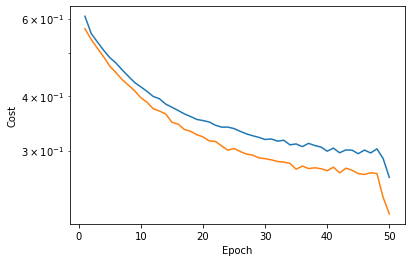

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   61
Train_loss = 0.172 | Test_loss = 0.162
Train_acc = 93.0% | Test_acc = 93.3%
==> EarlyStop patience = 1


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   62
Train_loss = 0.165 | Test_loss = 0.161
Train_acc = 93.6% | Test_acc = 93.5%
==> EarlyStop patience = 2


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   63
Train_loss = 0.158 | Test_loss = 0.152
Train_acc = 93.9% | Test_acc = 94.0%
==> EarlyStop patience = 3


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   64
Train_loss = 0.161 | Test_loss = 0.159
Train_acc = 93.7% | Test_acc = 94.0%
==> EarlyStop patience = 4


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   65
Train_loss = 0.156 | Test_loss = 0.149
Train_acc = 93.8% | Test_acc = 94.0%
==> EarlyStop patience = 5


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   66
Train_loss = 0.154 | Test_loss = 0.147
Train_acc = 94.1% | Test_acc = 94.2%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   67
Train_loss = 0.156 | Test_loss = 0.159
Train_acc = 93.8% | Test_acc = 93.7%
==> EarlyStop patience = 1


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   68
Train_loss = 0.151 | Test_loss = 0.148
Train_acc = 94.1% | Test_acc = 94.1%
==> EarlyStop patience = 2


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   69
Train_loss = 0.143 | Test_loss = 0.141
Train_acc = 94.5% | Test_acc = 94.3%


100%|██████████| 51/51 [00:20<00:00,  2.44it/s]


Epoch   70
Train_loss = 0.144 | Test_loss = 0.146
Train_acc = 94.0% | Test_acc = 94.2%
==> EarlyStop patience = 1


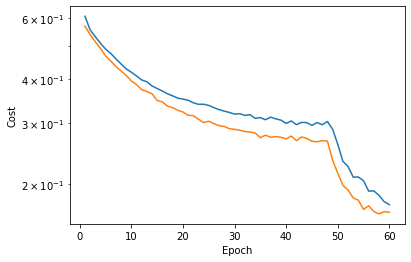

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   71
Train_loss = 0.134 | Test_loss = 0.144
Train_acc = 94.6% | Test_acc = 93.8%
==> EarlyStop patience = 2


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   72
Train_loss = 0.140 | Test_loss = 0.142
Train_acc = 93.9% | Test_acc = 94.3%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   73
Train_loss = 0.136 | Test_loss = 0.147
Train_acc = 94.8% | Test_acc = 94.4%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   74
Train_loss = 0.132 | Test_loss = 0.146
Train_acc = 95.1% | Test_acc = 94.2%
==> EarlyStop patience = 1


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   75
Train_loss = 0.130 | Test_loss = 0.143
Train_acc = 94.7% | Test_acc = 94.1%
==> EarlyStop patience = 2


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   76
Train_loss = 0.134 | Test_loss = 0.140
Train_acc = 94.7% | Test_acc = 94.2%
==> EarlyStop patience = 3


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   77
Train_loss = 0.132 | Test_loss = 0.143
Train_acc = 94.8% | Test_acc = 94.7%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   78
Train_loss = 0.131 | Test_loss = 0.141
Train_acc = 95.0% | Test_acc = 94.6%
==> EarlyStop patience = 1


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   79
Train_loss = 0.126 | Test_loss = 0.138
Train_acc = 95.0% | Test_acc = 94.5%
==> EarlyStop patience = 2


100%|██████████| 51/51 [00:20<00:00,  2.55it/s]


Epoch   80
Train_loss = 0.116 | Test_loss = 0.141
Train_acc = 95.4% | Test_acc = 94.5%
==> EarlyStop patience = 3


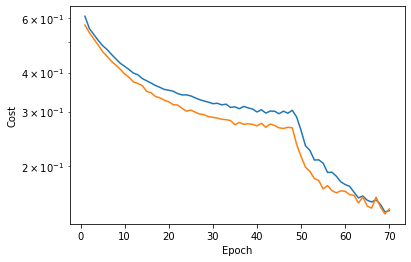

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   81
Train_loss = 0.117 | Test_loss = 0.147
Train_acc = 95.5% | Test_acc = 94.0%
==> EarlyStop patience = 4


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   82
Train_loss = 0.120 | Test_loss = 0.145
Train_acc = 95.5% | Test_acc = 94.3%
==> EarlyStop patience = 5


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   83
Train_loss = 0.118 | Test_loss = 0.137
Train_acc = 95.0% | Test_acc = 94.2%
==> EarlyStop patience = 6


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   84
Train_loss = 0.115 | Test_loss = 0.138
Train_acc = 95.5% | Test_acc = 94.3%
==> EarlyStop patience = 7


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   85
Train_loss = 0.115 | Test_loss = 0.139
Train_acc = 95.4% | Test_acc = 94.9%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   86
Train_loss = 0.105 | Test_loss = 0.149
Train_acc = 95.9% | Test_acc = 93.9%
==> EarlyStop patience = 1


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   87
Train_loss = 0.115 | Test_loss = 0.142
Train_acc = 94.9% | Test_acc = 93.8%
==> EarlyStop patience = 2


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   88
Train_loss = 0.101 | Test_loss = 0.136
Train_acc = 96.2% | Test_acc = 94.9%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   89
Train_loss = 0.114 | Test_loss = 0.146
Train_acc = 95.7% | Test_acc = 93.9%
==> EarlyStop patience = 1


100%|██████████| 51/51 [00:20<00:00,  2.55it/s]


Epoch   90
Train_loss = 0.107 | Test_loss = 0.138
Train_acc = 95.2% | Test_acc = 94.8%
==> EarlyStop patience = 2


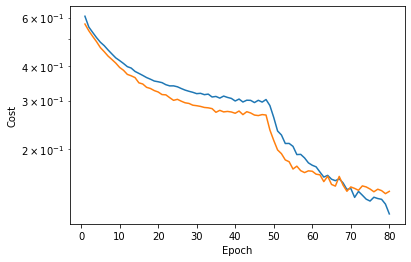

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   91
Train_loss = 0.103 | Test_loss = 0.135
Train_acc = 96.3% | Test_acc = 94.7%
==> EarlyStop patience = 3


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   92
Train_loss = 0.109 | Test_loss = 0.140
Train_acc = 95.8% | Test_acc = 95.1%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   93
Train_loss = 0.104 | Test_loss = 0.139
Train_acc = 95.3% | Test_acc = 94.5%
==> EarlyStop patience = 1


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   94
Train_loss = 0.103 | Test_loss = 0.138
Train_acc = 96.1% | Test_acc = 94.6%
==> EarlyStop patience = 2


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   95
Train_loss = 0.088 | Test_loss = 0.132
Train_acc = 96.3% | Test_acc = 94.9%
==> EarlyStop patience = 3


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   96
Train_loss = 0.102 | Test_loss = 0.140
Train_acc = 96.2% | Test_acc = 94.6%
==> EarlyStop patience = 4


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   97
Train_loss = 0.104 | Test_loss = 0.141
Train_acc = 96.1% | Test_acc = 94.8%
==> EarlyStop patience = 5


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   98
Train_loss = 0.094 | Test_loss = 0.137
Train_acc = 96.7% | Test_acc = 94.6%
==> EarlyStop patience = 6


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch   99
Train_loss = 0.101 | Test_loss = 0.143
Train_acc = 96.0% | Test_acc = 94.3%
==> EarlyStop patience = 7


100%|██████████| 51/51 [00:19<00:00,  2.57it/s]


Epoch  100
Train_loss = 0.096 | Test_loss = 0.149
Train_acc = 96.4% | Test_acc = 94.2%
==> EarlyStop patience = 8


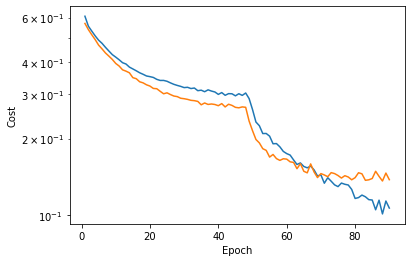

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch  101
Train_loss = 0.089 | Test_loss = 0.133
Train_acc = 96.7% | Test_acc = 95.1%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch  102
Train_loss = 0.088 | Test_loss = 0.137
Train_acc = 96.8% | Test_acc = 94.9%
==> EarlyStop patience = 1


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch  103
Train_loss = 0.082 | Test_loss = 0.135
Train_acc = 97.1% | Test_acc = 95.4%


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch  104
Train_loss = 0.090 | Test_loss = 0.134
Train_acc = 96.4% | Test_acc = 94.8%
==> EarlyStop patience = 1


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch  105
Train_loss = 0.088 | Test_loss = 0.131
Train_acc = 96.8% | Test_acc = 95.1%
==> EarlyStop patience = 2


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch  106
Train_loss = 0.093 | Test_loss = 0.133
Train_acc = 96.1% | Test_acc = 94.9%
==> EarlyStop patience = 3


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch  107
Train_loss = 0.088 | Test_loss = 0.133
Train_acc = 96.6% | Test_acc = 95.2%
==> EarlyStop patience = 4


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch  108
Train_loss = 0.082 | Test_loss = 0.137
Train_acc = 96.9% | Test_acc = 94.8%
==> EarlyStop patience = 5


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch  109
Train_loss = 0.085 | Test_loss = 0.134
Train_acc = 96.8% | Test_acc = 95.0%
==> EarlyStop patience = 6


100%|██████████| 51/51 [00:20<00:00,  2.46it/s]


Epoch  110
Train_loss = 0.089 | Test_loss = 0.138
Train_acc = 96.7% | Test_acc = 95.0%
==> EarlyStop patience = 7


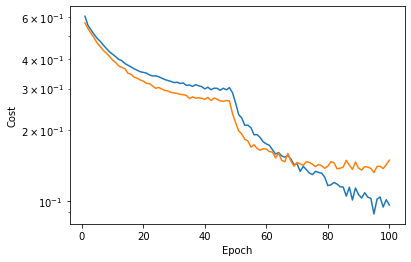

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch  111
Train_loss = 0.084 | Test_loss = 0.135
Train_acc = 97.0% | Test_acc = 94.7%
==> EarlyStop patience = 8


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch  112
Train_loss = 0.078 | Test_loss = 0.139
Train_acc = 96.4% | Test_acc = 94.7%
==> EarlyStop patience = 9


100%|██████████| 51/51 [00:19<00:00,  2.58it/s]


Epoch  113
Train_loss = 0.073 | Test_loss = 0.139
Train_acc = 97.1% | Test_acc = 94.8%
==> EarlyStop patience = 10
==> Execute Early Stopping


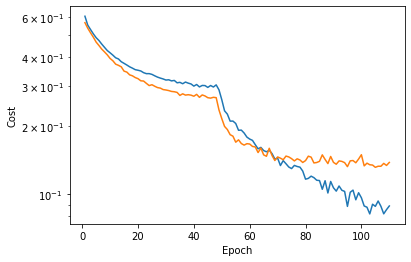

In [14]:
import os
while True:
    epoch += 1
    
    ## Training ##
    cost = acc = 0
    model.train()    
    for images, labels in tqdm(trainloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        cost += loss.item()*images.shape[0]
        labels = labels.cpu().detach().numpy()
        pred = output > 0.5
        pred = pred.cpu().detach().numpy()                
        acc += (1-hamming_loss(labels, pred))
    scheduler.step(cost)
    train_cost.append(cost/len(trainloader.dataset))
    train_acc.append(acc/len(trainloader))
    
    ## Testing ##
    with torch.no_grad():
        cost = acc = 0
        model.eval()
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
        
            output = model(images)
            loss = criterion(output, labels)            
            
            cost += loss.item()*images.shape[0]
            labels = labels.cpu().detach().numpy()
            pred = output > 0.5
            pred = pred.cpu().detach().numpy()                
            acc += (1-hamming_loss(labels, pred))
        scheduler.step(cost)
        test_cost.append(cost/len(testloader.dataset))
        test_acc.append(acc/len(testloader))
        
    ## Reporting ##
    print(f'Epoch {epoch:4}')
    print(f'Train_loss = {train_cost[-1]:.3f} | Test_loss = {test_cost[-1]:.3f}')
    print(f'Train_acc = {train_acc[-1]*100:.1f}% | Test_acc = {test_acc[-1]*100:.1f}%')    
    
    
    ## Common Callback ##
    # Early Stopping
    if test_acc[-1] > best_acc:
        best_acc = test_acc[-1]
        best_weights = model.state_dict()
        early_stop = 0
    else:
        early_stop += 1
        print(f'==> EarlyStop patience = {early_stop}')
        if early_stop >= early_stop_patience:
            print('==> Execute Early Stopping')
            ckpt = {
                'loss_history': (train_cost, test_cost),
                'acc_history': (train_acc, test_acc),
                'weight': best_weights
            }
            os.makedirs('model', exist_ok=True)
            torch.save(ckpt, f'model/{model_name}')
            break

    # Checkpoint            
    if epoch % save_every == 0:
        ckpt = {
            'loss_history': (train_cost, test_cost),
            'acc_history': (train_acc, test_acc),
            'weight': best_weights
        }
        os.makedirs('model', exist_ok=True)
        torch.save(ckpt, f'model/{model_name}')
        
    # Runtime Plotting
    if epoch % plot_every == 0:
        plt.pause(0.001)
        plt.semilogy(range(1, len(train_cost)+1), train_cost)
        plt.semilogy(range(1, len(test_cost)+1), test_cost)
        plt.ylabel('Cost')
        plt.xlabel('Epoch');

# Sanity Check

In [15]:
from torchvision.models import resnet18
model = resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 5),
    nn.Sigmoid()
)

ckpt = torch.load("model/resnet_finetuned.pth", map_location='cpu')
model.load_state_dict(ckpt['weight'])
model = model.to(device)

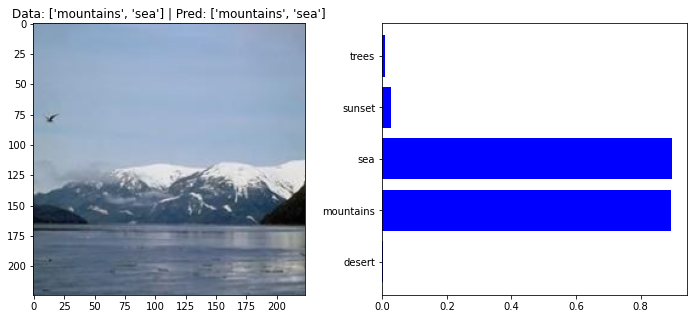

In [17]:
with torch.no_grad():
    model.eval()
    images, labels = next(iter(testloader))
    images = images[0:1, :, :, :].to(device)
    labels = labels[0].to(device)
    
    output = model(images)
    pred = output > 0.5
    
    images = inv_norm(images)
    
    images = images.squeeze().cpu().numpy().transpose([1, 2, 0])
    output = output.squeeze().cpu().numpy()
    pred = pred.squeeze().cpu().numpy()
    labels = labels.cpu().numpy()
    
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.imshow(images)
    plt.title(f"Data: {label2cat(labels)} | Pred: {label2cat(pred)}")
    plt.subplot(122)
    plt.barh(range(1,6), output, color='b', tick_label=["desert", "mountains", "sea", "sunset", "trees"]);